<H1><center>Project 4<BR><BR>
Recommender Systems</center></H1>
    
**UPDATE: Resubmitted 11/28! Happy Thanksgiving :) "
**Disclaimer: I ran out of late passes and wanted to at least submit the work I had completed so this version of my project 4 submission lacks much of task 3 at the moment.**

<H2>Task 1: Algorithmic Bias
</H2>

<P>Read <a href="https://cacm.acm.org/magazines/2016/10/207759-battling-algorithmic-bias/abstract">this article</a> about bias in algorithms.</P>

<P>Please address (minimum 200 words) the following questions in the space below. As the article describes, "common wisdom among programmers is to develop a pure algorithm that does not incorporate protected attributes into the model," where protected classes may include aspects such as race, gender, age, sexual orientation, and disability status. As a result, the algorithms can be bias. How might algorithms be evaluated for bias? Are there machine learning applications where you would sacrifice accuracy in order to reduce bias? Are there machine learning applications where you would allow bias in order to increase accuracy?</P>

Generally, I think that the developers of algorithms should attempt to reduce bias between groups of different protected classes while compromising the performance of the model as little as possible. I prioritize reducing bias because I believe that most often, the groups that will be disproportionately endangered by biased algorithms will be those that are already most at risk in society. I believe that there are several ways to evaluate algorithms for bias: First, we can examine how an algorithm performs on more diverse sets of testing data. In doing so, it is important to protect the privacy of diverse people represented in the data and ensure that their information cannot be traced back to them. Furthermore, we can also adjust our model to explore more complex relationships in data that might require it to go beyond a surface-level understanding of patterns involving complex human characteristics. I would sacrifice accuracy to reduce bias in issues that are more interpersonal in nature but don't have an underlying premise of improving safety: for instance, hiring. Conversely, I would allow for some bias in applications where immediate safety is directly concerned. Nonetheless, I remain concerned that if we allow for only the majority to be protected by our algorithms, we risk harming already vulnerable populations.

<H2>Task 2: Collaborative Filtering
</H2>

<P>In this task, you will use collaborative filtering to predict how a person might rate a business. Ratings are numbers between 1 and 5 corresponding, for example, to how many stars a person gives the business in a review. The data comes from the <a href="https://www.yelp.com/dataset/challenge">Yelp Dataset Challenge</a>.</P>

<P>To begin, read in the <code>training.csv</code> file containing <em>training</em> data. Unlike many other <code>CSV</code> files that we have worked with previously, the data are not in matrix form (rows and columns) here, but rather a list. Each line in the file contains three comma delimited values: the first corresponds to the ID of a person (user), the second correspond to the ID of a business (item), and the third corresponds to the rating (1 through 5) that the person gave the business in a review. The file contains over 80,000 lines, i.e., over 80,000 ratings that people gave to businesses. Write code below to create a user-item matrix, as described in class, from the data in the file. For each line in the file, you can think of the user (person) ID as indicating the row in the user-item matrix, the item (business) ID as indicating the column in the user-item matrix, and the rating as the value to be inserted in the user-item matrix at the specified row and column. Note that your user-item matrix will have many more than 80,000 entries even though the data contain only ~80,000 ratings. Thus, the matrix will be sparse, i.e., most values in the matrix should correspond to zero since each person rates only a small subset of all businesses.</P>

In [1]:
# Read in training data and create user-item matrix
import numpy as np
import pandas as pd
df = pd.read_csv('training.csv', header=None)
rows = df[0]
cols = df[1]
ratings = df[2]
df.head()

,0,1,2
0,4,323,5
1,830,1831,3
2,440,167,5
3,302,1801,5
4,917,3050,4


In [2]:
df.columns = ['User','Item','ItemRating']
sparse = df.pivot(index='User', columns='Item', values='ItemRating')

<P>Ultimately, our goal is to use filled-in (i.e., non-zero) values in the user-item matrix to predict empty (i.e., zero) values in the user-item matrix. In other words, we want to predict how a person might rate a business, based on how a person has rated other businesses or how a business has been rated by other people. Collaborative filtering.</P>

<P>Below, write a function named <code>prediction</code> that predicts a value (i.e., rating) for a given location (row index and column index) in the user-item matrix. Your prediction algorithm should proceed as follows:<BR>
<UL>
<li>Determine all rows in the matrix that contain non-zero values in the specified column. This will give us information on all people that rated the business of interest.</li>
<li>Using the <code>sklearn</code> unsupervised <code><a href="http://scikit-learn.org/stable/modules/neighbors.html">NearestNeighbors</a></code> algorithm, for the specified row in the user-item matrix, compute the <em>k</em> nearest neighbors among the rows that contain non-zero values in the specified column. This will give us the <em>k</em> most similar people that rated the business of interest. You should use the <code>cosine</code> metric in the <code>NearestNeighbors</code> algorithm for computing distance between rows in a matrix. If there are fewer than <em>k</em> people who have rated the business, you can use everyone who rated the business rather than the <em>k</em> most similar people (since there aren't <em>k</em> such people.</li>
<li>For the <em>k</em> nearest neighbors of the specified row, compute and return the mean value for the specified column. This will give us the average rating of the business from the <em>k</em> most similar people to the person of interest. In other words, we are predicting how someone will rate a business based on the ratings of similar people who have already rated the business.</li>
</UL><BR>
Your <code>prediction</code> function should have at least four inputs: your user-item matrix, a paramter <em>k</em>, a specified row, and a specified column (as well as any other input parameters that you deem helpful). 

In [3]:
# The *prediction* function takes in four (or more) parameters corresponding to
# the user-item matrix, k, the row (person) index, and the column (business) index.
# The function returns the average (mean) rating of a business from the k most
# similar people to the specified person.

from sklearn.neighbors import NearestNeighbors

def prediction(ui, k, row, col):
    item = ui[:][col] #all users at specific column
    xrow = ui.iloc[row].fillna(0) #user that we want to find rating for
    xrow = xrow.as_matrix()
    itemRows = np.argwhere(item.notnull().values).tolist()
    
    userRows = [] #make flat version of itemRows
    for sublist in itemRows:
        for i in sublist:
            userRows.append(i)
            
    #make a new dataframe of users that have ratings at specified columns
    df2 = ui.iloc[userRows]
    df2 = df2.fillna(0)
    
    #set # of neighbors depending on number of matching users
    if df2.shape[0] >= k:
        model = NearestNeighbors(metric='cosine', n_neighbors=k).fit(df2)
    if df2.shape[0] < k:
        model = NearestNeighbors(metric='cosine', n_neighbors=df2.shape[0]).fit(df2)
    
    #find neighbors for user of interest at column of interest
    dist, indices = model.kneighbors(xrow.reshape(1,-1))
    
    #compute average rating based on ratings of neighbors
    avgList = []
    for row in indices[0]:
        avgList.append(df2.iloc[row][col])
    mean = np.mean(avgList)
    return(mean)

<P>Let's evaluate how well we do at predicting people's ratings of businesses. The file <code>testing.csv</code> contains approximately 4,000 ratings that different people have given to different businesses. These <em>testing</em> ratings correspond to ~4,000 entries in the user-item matrix that contain zero values. So we can use the user-item matrix (our <em>training</em> data) to predict ratings in these ~4,000 cases and compare our predictions to the actual rating found in the <em>testing</em> data in order to see how accurate our predicted ratings are.</P>

<P>Write code below that reads in <em>testing</em> data from <code>testing.csv</code>. Each line in the file contains three comma delimited values: the first corresponds to the ID of a person (user), the second correspond to the ID of a business (item), and the third corresponds to the rating (1 through 5) that the person gave the business in a review. For each line, use the <code>prediction</code> function that you wrote above to predict the rating that the specified user might give the specified business. Keep track of this predicted rating as well as the actual rating from the <em>testing</em> data. After processing all lines in the <em>testing</em> file, you should have ~4,000 predicted ratings and the same number of actual ratings. To compare how far our predictions are from the actual ratings, we'll compute the root mean-squared error (RMSE) between the two, e.g., by computing the square root of the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">mean-squared error</a> (MSE). As a point of reference, the instructor found a RMSE a bit under 1.0 depending on the value of <em>k</em> used, i.e., the predicted ratings were a bit less than 1 "star" from the actual ratings on average. Try computing the RMSE on the <em>testing</em> data for each of the following eleven values for the parameter <em>k</em>: 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50.</P>

In [4]:
# Read in testing data and for each line in the file,
# calculate the predicted rating of the specified person and business.
# Compare the predicted ratings with the actual ratings in the testing data
# by computing the root mean-squared error (RMSE).
# Compute the RMSE for 11 different values of parameter k: 1,5,10,15,20,25,30,35,40,45,50

df = pd.read_csv('testing.csv', header=None)
df.columns = ['User','Item','ItemRating']
df.columns = ['User','Item','ItemRating']

results = df[['ItemRating']]

df = df.drop(columns=['ItemRating'])
df.head()
ratings = np.zeros(df.shape[0])
for i in range(df.shape[0]):
    ratings[i] = prediction(sparse,10,df.iloc[i][0],df.iloc[i][1])
ratings

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


array([4.1, 3.5, 3.9, ..., 4.1, 3.9, 3.9])

In [5]:
trueList = [] #make flat version of results.values
for sublist in results.values:
    for i in sublist:
        trueList.append(i)
trueArr = np.asarray(trueList)
trueArr

array([5, 3, 4, ..., 5, 4, 4])

In [6]:
from sklearn.metrics import mean_squared_error
y_true = trueArr
y_pred = ratings
mean_squared_error(y_true, y_pred)

0.8743359918901499

In [7]:
ks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ratingsK = np.zeros((len(ks),df.shape[0]))
rmsArr = np.zeros(len(ks))
for k in range(len(ks)):
    for i in range(df.shape[0]):
        ratingsK[k][i] = prediction(sparse,ks[k],df.iloc[i][0],df.iloc[i][1])
    rmsArr[k] = mean_squared_error(y_true, ratingsK[k])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
rmsArr

array([1.44915062, 0.94519466, 0.87433599, 0.86201803, 0.85863899,
       0.85894258, 0.8591207 , 0.8597084 , 0.8596854 , 0.85918819,
       0.86063692])

<P><font color="maroon"><u>For which of the eleven values of <em>k</em> do you observe the smallest RMSE? What is the RMSE at this optimal value of <em>k</em>?<u></font></P>

The lowest RMSE was 0.85863899 at k = 20

<P>Above, you predicted how a user might rate a business by seeing how similar users rated the same business (and taking the average value of these similar users' ratings of the business). As an alternative method for predicting the rating a user might give to a business, we could look at similar <em>businesses</em> rather than similar <em>users</em>. In this alternative approach, we will take our user and find similar <em>businesses</em> that they have rated. Our predicted rating will be the mean value of the user's ratings of <em>k</em> similar businesses. Below, write code to compute the RMSE between predicted ratings and actual ratings using eleven different values for the parameter <em>k</em>: 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50. Predicted ratings should be determined by calculating, among businesses rated by a specified user, the average rating that the user gave to the <em>k</em> most similar businesses. <em>Hint: You needn't change your <code>prediction</code> function above. Changing a single line of code elsewhere may be sufficient.</em></P>

In [9]:
# Read in testing data and for each line in the file,
# calculate the predicted rating of the specified person and business.
# Compare the predicted ratings with the actual ratings in the testing data
# by computing the root mean-squared error (RMSE).
# Compute the RMSE for 11 different values of parameter k: 1,5,10,15,20,25,30,35,40,45,50

df3 = pd.read_csv('training.csv', header=None)
df3.columns = ['User','Item','ItemRating']
sparse3 = df3.pivot(index='Item', columns='User', values='ItemRating')
sparse3.head()

User,0,1,2,3,4,5,6,7,8,9,...,908,909,910,911,912,913,914,915,916,917
Item,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df3T = pd.read_csv('testing.csv', header=None)
df3T.columns = ['User','Item','ItemRating']
df3T.columns = ['User','Item','ItemRating']

results3 = df3T[['ItemRating']]

df3T = df3T.drop(columns=['ItemRating'])
df3T.head()

ratings = np.zeros(df3T.shape[0])
for i in range(df3T.shape[0]):
    ratings[i] = prediction(sparse3,10,df3T.iloc[i][1],df3T.iloc[i][0])
ratings

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


array([3.9, 3.5, 3.7, ..., 2.9, 3.5, 3.5])

In [11]:
trueList = [] #make flat version of results.values
for sublist in results3.values:
    for i in sublist:
        trueList.append(i)
trueArr = np.asarray(trueList)
trueArr

array([5, 3, 4, ..., 5, 4, 4])

In [12]:
ksT = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ratingsKT = np.zeros((len(ksT),df3T.shape[0]))
rmsArrT = np.zeros(len(ksT))
for k in range(len(ksT)):
    for i in range(df3T.shape[0]):
        ratingsKT[k][i] = prediction(sparse3,ksT[k],df3T.iloc[i][1],df3T.iloc[i][0])
    rmsArrT[k] = mean_squared_error(trueArr, ratingsKT[k])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [13]:
rmsArrT

array([1.59479049, 0.95605889, 0.88927366, 0.86871762, 0.85748533,
       0.85316512, 0.84970183, 0.84752743, 0.84711902, 0.84662163,
       0.84849161])

<P><font color="maroon"><u>For which of the eleven values of <em>k</em> do you observe the smallest RMSE? What is the RMSE at this optimal value of <em>k</em>?<u></font></P>

Smallest RMSE = 0.84662163 at k = 45

<P><font color="maroon"><u>For their optimal values of parameter <em>k</em>, which approach led to more accurate predictions: (1) among users that have rated a business, finding the average rating that the <em>k</em> most similar users gave the business or (2) among businesses rated by a user, finding the average rating that the user gave to the <em>k</em> most similar businesses?<u></font></P>

(2) led to more accurate predictions since we achieved a lower RMSE than from (1)

<H2>Task 3: Content Based Recommendations
</H2>

<P>In Task 2 above, you predicted ratings based only on other ratings, e.g., based on the ratings different users gave the same business or based on ratings the same user gave different businesses. But what if you used other data about users or businesses to make predictions? For example, you might consider a business's type, market, location, or revenue when making predictions or a user's demographic info, spending habits, or preference for different business types when making predictions. Content based recommendations.</P>

<P>Here, we will consider the text of users' reviews of businesses to predict whether a user is likely to write a review of some other business or not. We will again use data from the <a href="https://www.yelp.com/dataset/challenge">Yelp Dataset Challenge</a> but this time, rather than using ratings (1 through 5), we will use reviews (e.g., "Food was great, service was fast. I would eat here again.").
</P>

<P>To begin, read in the file <code>businesses.txt</code>, which contains the reviews of ~3,000 businesses in the Las Vegas area. Each line of the file contains the ID of a business followed by a tab followed by all the reviews for the business concatenated together. Thus, if 30 people reviewed a particular business, the line in the file corresponding to the business would have the business's ID followed by all 30 reviews aggregated together. You should store the business IDs in one list and the corresponding business reviews in a second list that will serve as a corpus of text documents.</P>

In [17]:
# Read in file containing business IDs and business reviews.
# Create two lists, one to store business IDs and one to store business reviews.

data = []
filereader = open('businesses.txt','r')
file = filereader.readline()
while(file):
    file = file.replace('\n','').replace('\\n','').replace('\\','').split('\t')
    data.append(file)
    file = filereader.readline()
filereader.close()
ids = [file[0] for file in data]
revs = [file[1] for file in data]

<P>Featurize the corpus of business reviews as bag-of-words and TF-IDF weighting (remember Exercise 3?) using <code>sklearn</code>'s <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html"><code>TfidVectorizer</code></a>. Use both bi-grams and uni-grams for features rather than just uni-grams. With uni-grams, we might have ~80,000 features, but with bi-grams as well, we'll have ~2 million features.
<em>HINT: by default, the <code>transform</code> and <code>fit_transform</code> functions of a <code>TfidfVectorizer</code> will return sparse matrices, which are efficient to work with. In some cases, invoking the <code>toarray</code> function is desirable to convert the matrices to traditional <code>numpy</code> arrays, but in this case, you should not use the <code>toarray</code> function as working with the default sparse matrices is important for efficiency given the large size of the dataset that you are working with.</em></P>

In [22]:
# Extract features from text of reviews using bag-of-words with TF-IDF weighting.
# As features, use bi-grams rather than uni-grams.
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(ngram_range=(1, 2),smooth_idf=True)
X_train = v.fit_transform(revs)

<P>The <em>testing</em> data relates to 400 users and comes in two files. The file <code>test_reviews.txt</code> contains 400 lines, one for each user, where each line contains a user's ID followed by a tab followed by the text of all the user's reviews concatenated together. The file <code>test_business.txt</code> also contains 400 lines, one for each user, where each line contains a user's ID followed by a tab followed by a tab delimited list of business IDs for the businesses that the user has reviewed. Below, write code to read in the data from the two files, <code>test_reviews.txt</code> and <code>test_business.txt</code>. For the text of users' reviews, you should featurize the text using the <code>TfidVectorizer</code> that you instantiated and trained above, so that you will have matrix (array) with 400 rows (one per user) and over 2 million columns (corresponding to the bi-gram features). <em>HINT: once again, it is recommended that after invoking the <code>transform</code> function on a <code>TfidfVectorizer</code> that you use the returned sparse matrix for efficiency reasons and not convert the matrix to a <code>numpy</code> array using the <code>toarray<code> function.</em></P>

In [26]:
# Read in test data from two files containing (1) text of each user's reviews and 
# (2) the business IDs for the businesses that each user has reviewed.
# Featurize the text of users' reviews using the trained TfidVectorizer created earlier.

datat = [[],[]]
filereader = open('test_businesses.txt','r')
file = filereader.readline()
while(file):
    file = file.replace('\n','').replace('\\n','').replace('\\','').split('\t')
    datat[0].append(file[0])
    datat[1].append(file[1:])
    file = filereader.readline()
filereader.close()
usert = datat[0]
bizt = datat[1]

data = []
filereader = open('test_reviews.txt','r')
file = filereader.readline()
while(file):
    file = file.replace('\n','').replace('\\n','').replace('\\','').split('\t')
    data.append(file)
    file = filereader.readline()
filereader.close()
idst = [file[0] for file in data]
revst = [file[1] for file in data]

X_test = v.transform(revst)


<P>It is not easy to predict what new businesses a user will review in the future based only on the text of a user's previous reviews (we are not even considering which businesses the user has visited previously or the locations of businesses!). But we'll give it a try. Expect the accuracy of our predictions to be low.</P>

<P>In order to predict the businesses that a user is likely to review, we'll compare the text of all reviews (from other users) for a business with the text of all reviews from a user. If the text of a business's reviews is similar (i.e., has similar bi-gram features) to the text of a user's reviews, we will predict that the user will review the business. Using <code>sklearn</code>'s <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html"><code>cosine_similarity</code></a> function, write code below to compute the similarity of each user's featurized text reviews with each business's featurized text reviews.</P>

In [27]:
# Using sklearn's cosine_similarity function, compute the similarity of 
# each user's featurized text reviews with each business's featurized text reviews.

from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X_test,X_train)

In [28]:
sim

array([[0.58946464, 0.69378544, 0.48963578, ..., 0.07053503, 0.11905741,
        0.14119936],
       [0.59327065, 0.70905669, 0.4831291 , ..., 0.0558425 , 0.11536009,
        0.13263431],
       [0.06284071, 0.07718672, 0.04912917, ..., 0.00907744, 0.020372  ,
        0.01791243],
       ...,
       [0.61330119, 0.69960985, 0.51542029, ..., 0.06496702, 0.11151165,
        0.14181744],
       [0.16734157, 0.18593662, 0.1260974 , ..., 0.02379909, 0.03792786,
        0.05322412],
       [0.13095775, 0.15526743, 0.11000622, ..., 0.01270252, 0.02107398,
        0.02455734]])

<P>For a given similarity threshold, say 0.5, we'll predict that a user will review a business if the similarity betweeen the featurized text of their reviews and the featurized text of the business's reviews is above the threshold. In this way, for a given similarity threshold, we can predict whether each user will review each business.</P>

<P>We also want to evalute our predictions. Do the businesses that we predict a user will review correspond to the actual businesses that a user has reviewed (from the file <code>test_business.txt</code>)? Write a function <code>evaluate</code> below that predicts the businesses each user will review and then evaluates these predictions. The predictions should be evaluated by computing whether the predictions correspond to true positives, false positives, true negatives, or false negatives. A true positive prediction occurs when we predict a user will review a business and the user has actually reviewed that business. A false positive prediction occurs when we predict a user will review a business but the user has not actually reviewed that business. A true negative prediction occurs when we do not predict a user will review a business and the user has not actually reviewed the business. A false negative prediction occurs when we do not predict a user will review a business but the user has actually reviewed the business. The <code>evaluate</code> function should compute, for a given similarity threshold, the true positives, false positives, true negatives, and false negatives for all users possibly reviewing all businesses. The function should return the recall and the precision of all possible predictions for a given similarity threshold. As input the function should take a similarity threshold as well as any other input parameters you deem appropriate. You should then execute your <code>evaluate</code> function using eleven different similarity threshold values: 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, and determine the recall and precision for each.</P>

In [31]:
# Design a function *evaluate* that takes a similarity threshold as input
# along with any other appropriate input parameters. The function should
# predict for each user the set of businesses that the user is likely to
# review by determing if the user's featurized text reviews are similar
# (above the threshold) to a business's featurized text reviews.
# The function should return the recall and precision of all predictions
# by evaluating whether the predictions correspond to actual businesses 
# reviewed by users.
# As a final step, the function should be executing using 11 different
# similarity thresholds: 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
# so that 11 recall and precision values are determined.
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
thresh = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def evaluate(t,sim,revs):
    pred = np.greater_equal(sim,t)
    TP = np.sum(np.logical_and(pred==True,revs==True))
    FP = np.sum(np.logical_and(pred==True,revs==False))
    TN = np.sum(np.logical_and(pred==False,revs==False))
    FN = np.sum(np.logical_and(pred==False,revs==True))
    precision = (TP+1)/((TP+FP)+1)
    recall = TP/(TP+FN)            
    return precision,recall
treviews = np.array([np.isin(ids,bizt[i]) for i in range(len(bizt))])          
evaluate(0.5,sim,treviews)
p = []
r = []
for t in thresh:
    scores = evaluate(t,sim,treviews)
    p.append(scores[0])
    r.append(scores[1])

<P><font color="maroon"><u>Below, write code to plot the recall and precision using the eleven different similarity threhsolds. Your plot might look something like this:<BR>
<center><img src="recall_precision.png" width=300></img></center><u></font></P>

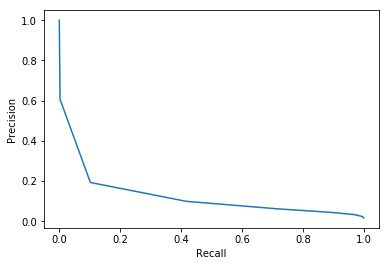

In [34]:
# Plot recall and precision of predictions using eleven different similarity thresholds.


import matplotlib.pyplot as plt
plt.plot(r,p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


<P><font color="maroon"><u>Below, write code to calculate and plot the F1 score on the y-axis and the eleven different similarity threhsolds on the x-axis. Your plot might look something like this:<BR>
<center><img src="f1.png" width=300></img></center><u></font></P>

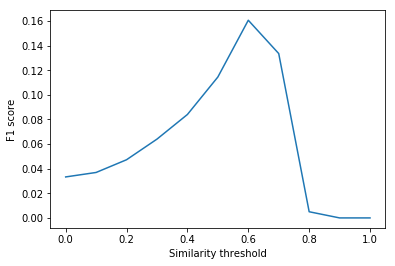

In [38]:
# Compute and plot F1 score of predictions using eleven different similarity thresholds.

f1 = np.zeros(len(p))
for i in range(len(p)):
    f1[i] = 2*(p[i]*r[i])/(p[i]+r[i])
plt.plot(thresh,f1)
plt.xlabel("Similarity threshold")
plt.ylabel("F1 score")
plt.show()

<H2>Submitting your work
</H2>

<P><font color="maroon"><u>Please indicate your name and the names of any partner that worked with you on this project:</u></font></P>

Name(s): Shreya Parjan

<P><font color="maroon"><u>Please indicate anyone else that you collaborated with in the process of doing the project:</u></font></P>

Collaborators: 

<P><font color="maroon"><u>If you or your partner is using a late coupon, please indicate who is using the coupon and how many coupons:</u></font></P>

Late coupons: Shreya Parjan, all
**Disclaimer: I ran out of late passes and wanted to at least submit the work I had completed so this version of my project 4 submission lacks much of task 3 at the moment.**

<P><font color="maroon"><u>When working on this project, approximately how many hours did you spend on each of (1) Task 1, (2) Task 2, (3) Task 3, and (4) Total?</u></font></P>

Hours on Task 1: 0.5
Hours on Task 2: 8
Hours on Task 3: 0.5
Total hours: 9

<P><font color="maroon"><u>When working on this project, did you abide by the <a href="https://www.wellesley.edu/studentlife/aboutus/honor">Honor Code</a> and is all of the work that you are submitting your own and/or your partner's?</u></font></P>

Abide by Honor Code: yes

<P><font color="maroon"><u>To submit this project, please upload your <code>Project4.ipynb</code> file to the <code>Project4</code> folder that the instructor created and shared with you in your Google drive.</u></font></P>